# Analysis of Activation Functions
In this notebook I compare the performance of MLP using the Leaky ReLU and Sigmoid activation functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib import *

In [2]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 182 entries, activation_func to std_val_scores
dtypes: bool(1), float64(176), int64(2), object(3)
memory usage: 6.3+ MB


# The Best Configuration of Hyperparameters
My main question: given seven hyperparameters and the settings that I tested, what is the best combination/configuration? I will try answering this question in the context of the Iris dataset (trying to answer that question in the context of all of the six datasets tested on would be very difficult and time consuming!). The seven 'hyperparameters' (albeit some are not strictly hyperparameters, but network architectures/design choices) are: 
- activation_func - the activation function used in the hidden layer
- batch_size - the number of samples used in a single training step
- clf_type - a setting that affects the activation function for the output layer and the loss and scoring functions used
- gaussian_noise - the amount of noise added to the inputs
- learning_rate - the learning constant $\eta$
- momentum - the momentum constant (often seen as $\alpha$)
- shuffle_batches - whether or not the dataset, and subsequently the generated (mini) batches, are shuffled at the start of each epoch.

I will look at each hyperparameter in isolation to see if there are any strong effects, and try to see if there are any combinations of hyperparameters that are particulary performant.

## Exploratory Data Analysis
First off, I will have a quick look at what some of the best and worst configurations are.
Configurations are sorted by validation loss and training loss in ascending order, then by validation scores and training scores in descending order. The median values are used instead of the mean values to limit the effect of large outliers that are present in the data.

### Top Configurations
Looking at the top configurations,

In [53]:
# TODO: Split by regression/classification!

df_sorted = df[using_iris].sort_values(
    by=['median_val_loss', 'median_train_loss', 'median_val_scores', 'median_train_scores'],
    ascending=[True, True, False, False]
)

n = 20

In [54]:
print('Top %d Configurations sorted by Loss and Scores' % n)
df_sorted[variables + summary_stats].head(n)

Top 20 Configurations sorted by Loss and Scores


,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores
run_id,,,,,,,,,,,,,,,,,,,,
e67c32180625b68589824f2f266672f7,Sigmoid,1,MLPClassifier,iris,0.00,0.100,0.5,False,0.038529,0.041105,0.018633,0.983333,0.982292,0.012111,0.038529,0.041105,0.018633,0.983333,0.982292,0.012111
a448692b645d2738752afe979bd04ecf,Sigmoid,1,MLPClassifier,iris,0.01,0.100,0.5,False,0.043050,0.051549,0.025161,0.983333,0.982292,0.012402,0.043050,0.051549,0.025161,0.983333,0.982292,0.012402
1a77a1bce995f7a9d38985fbe7258f47,Sigmoid,1,MLPClassifier,iris,0.00,0.100,0.0,False,0.043303,0.045943,0.015004,0.983333,0.984167,0.012346,0.043303,0.045943,0.015004,0.983333,0.984167,0.012346
9dfc35a6a6e7217c7ca0a1dc92ebd7d1,Sigmoid,1,MLPClassifier,iris,0.01,0.100,0.0,False,0.043376,0.047056,0.016208,0.983333,0.984167,0.010971,0.043376,0.047056,0.016208,0.983333,0.984167,0.010971
3e1e31c1af129da3044117a4a2ddbedf,Sigmoid,1,MLPRegressor,iris,0.00,0.100,0.5,False,0.046927,0.050685,0.014569,0.985287,0.979207,0.019653,0.046927,0.050685,0.014569,0.985287,0.979207,0.019653
b05f504320771732bc61f2ed30f5fb9c,Sigmoid,1,MLPRegressor,iris,0.00,0.100,0.0,False,0.047770,0.051824,0.015040,0.985898,0.980408,0.016267,0.047770,0.051824,0.015040,0.985898,0.980408,0.016267
16661a901d2c047ca9bb5462a23688ea,LeakyReLU,1,MLPClassifier,iris,0.00,0.010,0.5,False,0.053297,0.061395,0.030497,0.975000,0.978958,0.013866,0.053297,0.061395,0.030497,0.975000,0.978958,0.013866
98a07b0b9ba2f48fb9a975dce29e00a7,Sigmoid,2,MLPClassifier,iris,0.00,0.100,0.0,False,0.055361,0.057976,0.016235,0.975000,0.978333,0.010642,0.055361,0.057976,0.016235,0.975000,0.978333,0.010642
38ec405669bfc515f57283fa3bf2220e,LeakyReLU,-1,MLPClassifier,iris,0.00,0.100,0.5,False,0.058010,0.122786,0.140177,0.975000,0.964792,0.024495,0.058010,0.122786,0.140177,0.975000,0.964792,0.024495


In [60]:
print('Summary of Categorical Columns')
print(df_sorted['activation_func'].head(n).value_counts())
print()
print(df_sorted['clf_type'].head(n).value_counts())
print()
print(df_sorted['shuffle_batches'].head(n).value_counts())

Summary of Categorical Columns
Sigmoid      15
LeakyReLU     5
Name: activation_func, dtype: int64

MLPClassifier    14
MLPRegressor      6
Name: clf_type, dtype: int64

False    18
True      2
Name: shuffle_batches, dtype: int64


In [45]:
df_sorted[variables + summary_stats].head(n).describe()

,activation_func,batch_size,clf_type,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.750000,1.550000,0.300000,0.002500,0.072550,0.250000,0.100000,0.054888,0.078489,0.053986,0.977404,0.970823,0.025551,0.054888,0.078489,0.053986,0.977404,0.970823,0.025551
std,0.444262,1.669384,0.470162,0.004443,0.043061,0.256495,0.307794,0.007916,0.039481,0.060459,0.005595,0.011902,0.019488,0.007916,0.039481,0.060459,0.005595,0.011902,0.019488
min,0.000000,-1.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.038529,0.041105,0.010762,0.965540,0.946491,0.009158,0.038529,0.041105,0.010762,0.965540,0.946491,0.009158
25%,0.750000,1.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.047559,0.051755,0.016228,0.975000,0.963802,0.012331,0.047559,0.051755,0.016228,0.975000,0.963802,0.012331
50%,1.000000,1.000000,0.000000,0.000000,0.100000,0.250000,0.000000,0.058867,0.062761,0.022828,0.975000,0.975921,0.017117,0.058867,0.062761,0.022828,0.975000,0.975921,0.017117
75%,1.000000,2.000000,1.000000,0.002500,0.100000,0.500000,0.000000,0.061251,0.084498,0.065452,0.983333,0.979508,0.031995,0.061251,0.084498,0.065452,0.983333,0.979508,0.031995
max,1.000000,8.000000,1.000000,0.010000,0.100000,0.500000,1.000000,0.061841,0.184090,0.191217,0.985898,0.984167,0.076218,0.061841,0.184090,0.191217,0.985898,0.984167,0.076218


In [46]:
print('Bottom %d Configurations sorted by Loss and Scores' % n)
df_sorted[variables + summary_stats].tail(n)

Bottom 20 Configurations sorted by Loss and Scores


,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores
run_id,,,,,,,,,,,,,,,,,,,,
daf496521da3c283a4a25dd9e69018da,0,8,0,iris,0.01,0.1,0.9,0,4.144653,3.577636e+00,1.375378e+00,0.333333,0.403333,0.191744,4.144653,3.577636e+00,1.375378e+00,0.333333,0.403333,0.191744
4decde8b3683ae186411937f2c0b92cb,0,16,0,iris,0.01,0.1,0.5,0,4.274705,4.335805e+00,3.837202e+00,0.312500,0.575195,0.312749,4.274705,4.335805e+00,3.837202e+00,0.312500,0.575195,0.312749
c9ea1be71c7c12b60e8272597d8332f5,0,1,0,iris,0.01,0.1,0.0,1,6.465393,6.093221e+00,4.255107e+00,0.333333,0.491667,0.262914,6.465393,6.093221e+00,4.255107e+00,0.333333,0.491667,0.262914
09660b29b02cea9470930eac690e1c49,0,32,1,iris,0.01,0.1,0.0,0,6.476146,2.875864e+146,1.818856e+147,-0.048537,0.270668,0.456439,6.476146,2.875864e+146,1.818856e+147,-0.048537,0.270668,0.456439
10a6891dc6c24555617679b8bd3d907e,0,16,0,iris,0.00,0.1,0.9,0,6.907755,5.888668e+00,3.630740e+00,0.312500,0.482812,0.281968,6.907755,5.888668e+00,3.630740e+00,0.312500,0.482812,0.281968
088313190f8ae944447fe3369d49adef,0,16,0,iris,0.01,0.1,0.9,0,6.907755,6.164372e+00,3.895768e+00,0.312500,0.465039,0.285426,6.907755,6.164372e+00,3.895768e+00,0.312500,0.465039,0.285426
54ef32bab72eed45a0c302d5919a74cb,0,16,0,iris,0.10,0.1,0.9,0,6.907755,5.965406e+00,4.208173e+00,0.312500,0.520117,0.287240,6.907755,5.965406e+00,4.208173e+00,0.312500,0.520117,0.287240
d62ddcf40ca60ddb85f8d3b830484a0c,0,1,0,iris,0.00,0.1,0.0,1,7.056121,6.662384e+00,3.464177e+00,0.333333,0.414583,0.183146,7.056121,6.662384e+00,3.464177e+00,0.333333,0.414583,0.183146
8cd33e1e19d27d8cc8019310fa7618f6,0,1,0,iris,0.10,0.1,0.0,1,7.313341,6.592806e+00,3.558285e+00,0.333333,0.430625,0.214863,7.313341,6.592806e+00,3.558285e+00,0.333333,0.430625,0.214863


In [61]:
print('Summary of Categorical Columns')
print(df_sorted['activation_func'].tail(n).value_counts())
print()
print(df_sorted['clf_type'].tail(n).value_counts())
print()
print(df_sorted['shuffle_batches'].tail(n).value_counts())

Summary of Categorical Columns
LeakyReLU    20
Name: activation_func, dtype: int64

MLPClassifier    11
MLPRegressor      9
Name: clf_type, dtype: int64

False    17
True      3
Name: shuffle_batches, dtype: int64


In [47]:
df_sorted[variables + summary_stats].tail(n).describe()

,activation_func,batch_size,clf_type,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores
count,20.0,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000
mean,0.0,22.950000,0.450000,0.034000,1.000000e-01,0.550000,0.150000,692.195988,1.673840e+149,1.058629e+150,0.141333,0.340520,0.342233,692.195988,1.673840e+149,1.058629e+150,0.141333,0.340520,0.342233
std,0.0,12.236593,0.510418,0.044533,1.423831e-17,0.400657,0.366348,2146.866664,6.318666e+149,3.996275e+150,0.206099,0.188701,0.093637,2146.866664,6.318666e+149,3.996275e+150,0.206099,0.188701,0.093637
min,0.0,1.000000,0.000000,0.000000,1.000000e-01,0.000000,0.000000,4.144653,3.577636e+00,1.375378e+00,-0.191459,0.010684,0.183146,4.144653,3.577636e+00,1.375378e+00,-0.191459,0.010684,0.183146
25%,0.0,16.000000,0.000000,0.000000,1.000000e-01,0.000000,0.000000,6.907755,6.146584e+00,3.881126e+00,-0.053309,0.161894,0.284561,6.907755,6.146584e+00,3.881126e+00,-0.053309,0.161894,0.284561
50%,0.0,32.000000,0.000000,0.010000,1.000000e-01,0.700000,0.000000,12.433960,9.353722e+00,7.593309e+00,0.312500,0.408958,0.312968,12.433960,9.353722e+00,7.593309e+00,0.312500,0.408958,0.312968
75%,0.0,32.000000,1.000000,0.100000,1.000000e-01,0.900000,0.000000,90.861835,2.098071e+137,1.326936e+138,0.312500,0.498779,0.427471,90.861835,2.098071e+137,1.326936e+138,0.312500,0.498779,0.427471
max,0.0,32.000000,1.000000,0.100000,1.000000e-01,0.900000,1.000000,9414.774997,2.801456e+150,1.771796e+151,0.333333,0.575195,0.469982,9414.774997,2.801456e+150,1.771796e+151,0.333333,0.575195,0.469982


## Extreme Values in Loss Metrics
Some configurations would occasionally have high loss, likely due to the ReLU configuration's loss exploding (this happened sometimes). Visually inspecting the data tells us that the main factor contribruting to this would be a learning rate of 0.1, as that is the only hyperparameter that is consistent amoung the cases where the loss exploded. This is clear with the maximum observed validation loss, where for models using a ReLU activation it is over 100 orders of magnitude larger than the maximum validation loss observed for models using the sigmoid activation - as shown in the table below:


|*Table: Maximum Observed Validation Loss by Model Activation Function*|
|-|

| Activation Function | Maximum Validation Loss |
|---------------------|-------------------------|
| ReLU                | 4.4136e+149             |
| Sigmoid             | 1.3816e+01              |

In [3]:
df[using_relu & using_iris][(df[using_relu & using_iris].filter(regex='val_loss_\d{2}') > 1e9).any(axis=1)].describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_loss_00,train_loss_01,train_loss_02,train_loss_03,train_loss_04,train_loss_05,...,mean_val_loss,mean_val_scores,median_train_loss,median_train_scores,median_val_loss,median_val_scores,std_train_loss,std_train_scores,std_val_loss,std_val_scores
count,78.000000,78.000000,7.800000e+01,78.000000,7.300000e+01,7.800000e+01,7.700000e+01,7.300000e+01,7.600000e+01,7.600000e+01,...,7.800000e+01,78.000000,78.000000,78.000000,78.000000,78.000000,7.800000e+01,78.000000,7.800000e+01,78.000000
mean,13.089744,0.037949,1.000000e-01,0.455128,3.048520e+123,8.551164e+126,1.668357e+144,6.603586e+144,2.398333e+111,1.335056e+74,...,4.291932e+148,0.555906,176.816873,0.559865,176.816873,0.559865,2.714456e+149,0.258402,2.714456e+149,0.258402
std,11.859771,0.045623,4.190284e-17,0.370905,2.604657e+124,7.552183e+127,1.463977e+145,5.642106e+145,2.090818e+112,1.163872e+75,...,3.223799e+149,0.230811,1109.083140,0.310678,1109.083140,0.310678,2.038910e+150,0.112239,2.038910e+150,0.112239
min,-1.000000,0.000000,1.000000e-01,0.000000,1.010895e-01,1.094438e-01,9.387092e-02,1.104296e-01,9.749550e-02,1.204758e-01,...,6.200613e-01,0.010684,0.127533,-0.191459,0.127533,-0.191459,2.975255e+00,0.026202,2.975255e+00,0.026202
25%,2.000000,0.000000,1.000000e-01,0.000000,1.608497e-01,2.598221e-01,1.525504e-01,1.971073e-01,2.239845e-01,2.207017e-01,...,8.857890e+46,0.453375,0.275376,0.398734,0.275376,0.398734,5.597249e+47,0.176346,5.597249e+47,0.176346
50%,8.000000,0.010000,1.000000e-01,0.500000,3.240527e-01,4.518206e-01,3.469570e-01,3.251768e-01,3.276729e-01,3.626017e-01,...,8.588765e+92,0.564598,0.373466,0.560199,0.373466,0.560199,5.360092e+93,0.237443,5.360092e+93,0.237443
75%,16.000000,0.100000,1.000000e-01,0.900000,9.659128e-01,8.639334e+02,1.394246e+02,1.017120e+00,1.001845e+00,6.456547e+00,...,1.353414e+127,0.721311,0.816536,0.822295,0.816536,0.822295,8.553636e+127,0.341919,8.553636e+127,0.341919
max,32.000000,0.100000,1.000000e-01,0.900000,2.225420e+125,6.669908e+128,1.284635e+146,4.820618e+146,1.822733e+113,1.014640e+76,...,2.801456e+150,0.927205,9414.774997,0.937257,9414.774997,0.937257,1.771796e+151,0.469982,1.771796e+151,0.469982


In [4]:
df[using_relu & using_iris][(df[using_relu & using_iris].filter(regex='val_loss_\d{2}') > 1e9).any(axis=1)]

,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,train_loss_00,train_loss_01,...,mean_val_loss,mean_val_scores,median_train_loss,median_train_scores,median_val_loss,median_val_scores,std_train_loss,std_train_scores,std_val_loss,std_val_scores
run_id,,,,,,,,,,,,,,,,,,,,,
c5eb49fa0f9d4ce25a0c145ed8a5a337,LeakyReLU,1,MLPRegressor,iris,0.00,0.1,0.0,True,3.015190e-01,3.205552e-01,...,6.033293e+00,0.581131,0.301519,0.535183,0.301519,0.535183,2.869354e+01,0.196052,2.869354e+01,0.196052
e13df1a75ba0bec88043802b1317049f,LeakyReLU,1,MLPRegressor,iris,0.10,0.1,0.5,False,NaN,1.539870e-01,...,6.200613e-01,0.927205,0.131849,0.932560,0.131849,0.932560,2.975255e+00,0.026202,2.975255e+00,0.026202
053ebc3ea2981661224576e41db1932d,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.9,True,4.916806e-01,5.194493e-01,...,1.708278e+93,0.518293,0.432518,0.475832,0.432518,0.475832,1.066820e+94,0.294226,1.066820e+94,0.294226
16caae5ffeca67e6c24cfefd39434739,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.9,False,4.288734e-01,1.762439e+00,...,2.417216e+74,0.484997,0.536533,0.484187,0.536533,0.484187,1.509551e+75,0.182029,1.509551e+75,0.182029
733892d6c136231a7ee0e7410152de94,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.5,True,1.381553e-01,6.369974e-01,...,1.521076e+75,0.671198,0.279484,0.754945,0.279484,0.754945,8.806020e+75,0.288366,8.806020e+75,0.288366
fd04834aaaef126fbd4fe67b405bf529,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.5,False,1.166580e-01,4.392295e-01,...,4.456696e+59,0.524704,0.527701,0.553733,0.527701,0.553733,2.818662e+60,0.193859,2.818662e+60,0.193859
8bc7305e675694eab29cf08a4ed18137,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.0,False,5.332008e-01,2.696087e+00,...,8.590216e+43,0.481907,0.708070,0.535058,0.708070,0.535058,5.432923e+44,0.155453,5.432923e+44,0.155453
d014d48b63a4a7b5c00dc6da68ee1a47,LeakyReLU,8,MLPRegressor,iris,0.10,0.1,0.9,True,3.240527e-01,3.828706e-01,...,9.837983e+106,0.521428,0.436629,0.517274,0.436629,0.517274,6.143818e+107,0.221391,6.143818e+107,0.221391
0385f5695765ce77a8b1a5cebd0d2a72,LeakyReLU,8,MLPRegressor,iris,0.10,0.1,0.9,False,3.303943e-01,7.515662e+20,...,2.475555e+144,0.476751,0.411618,0.550803,0.411618,0.550803,1.565676e+145,0.206314,1.565676e+145,0.206314


In [5]:
relu_max_loss = df[using_relu & using_iris].filter(regex='val_loss_\d{2}').max().max()
not_relu_max_loss = df[~using_relu & using_iris].filter(regex='val_loss_\d{2}').max().max()
print('Max loss with ReLU: %.4e \nMax loss with Sigmoid: %.4e' % (relu_max_loss, not_relu_max_loss))

Max loss with ReLU: 4.4136e+149 
Max loss with Sigmoid: 1.3816e+01


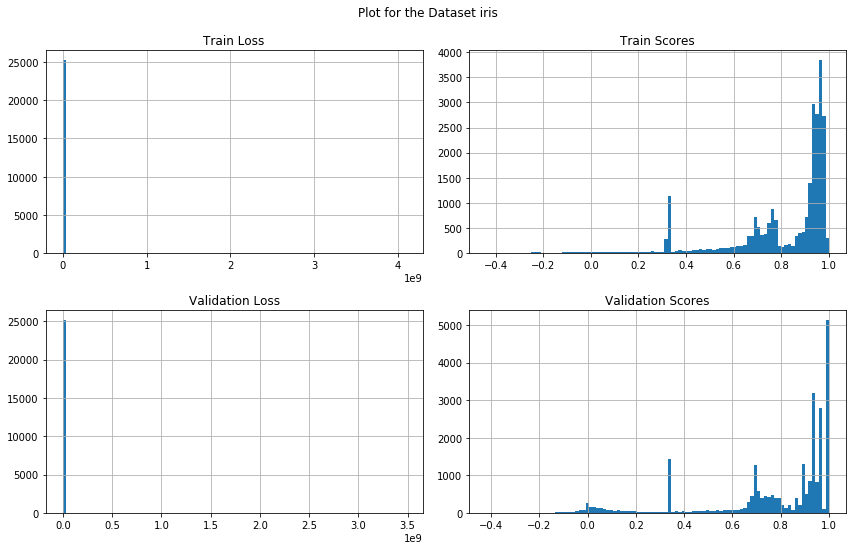

In [6]:
plot(df[using_relu & using_iris], thresholds=(2**32 - 1, -1, 2**32 - 1, -1))

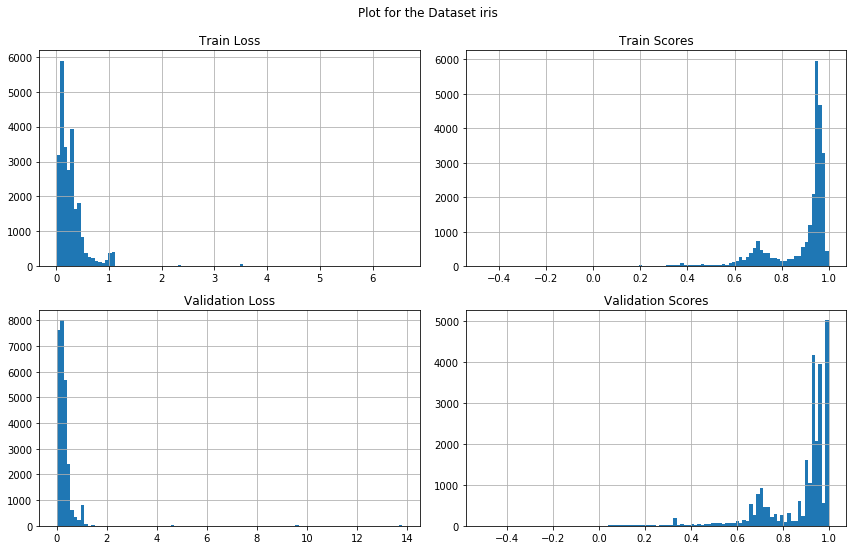

In [7]:
plot(df[~using_relu & using_iris], thresholds=(2**32 - 1, -1, 2**32 - 1, -1))

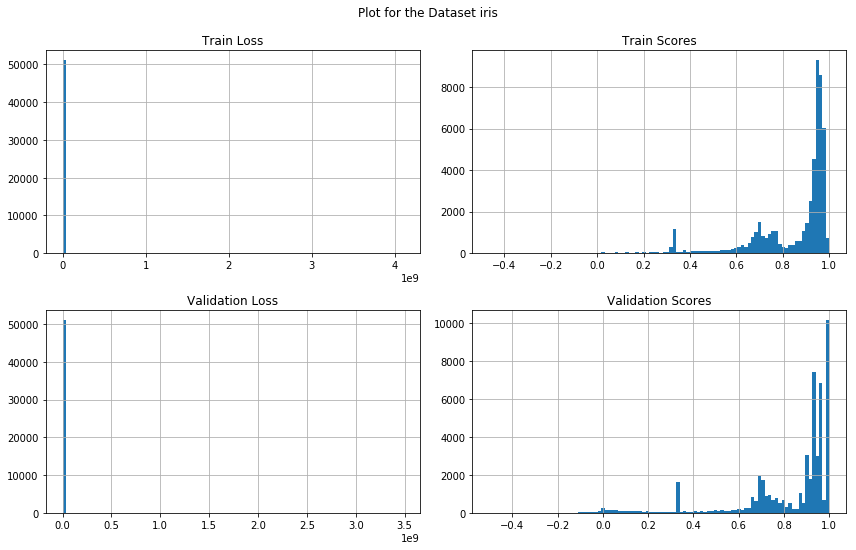

In [8]:
plot(df[using_iris], thresholds=(2**32 - 1, -1, 2**32 - 1, -1))

### Finding the Best Range of Loss to View
With some trial and error, the best range of loss values to view without losing too much information seem to be in the interval [0, 2].
Loss will be truncated to this interval from here on out.

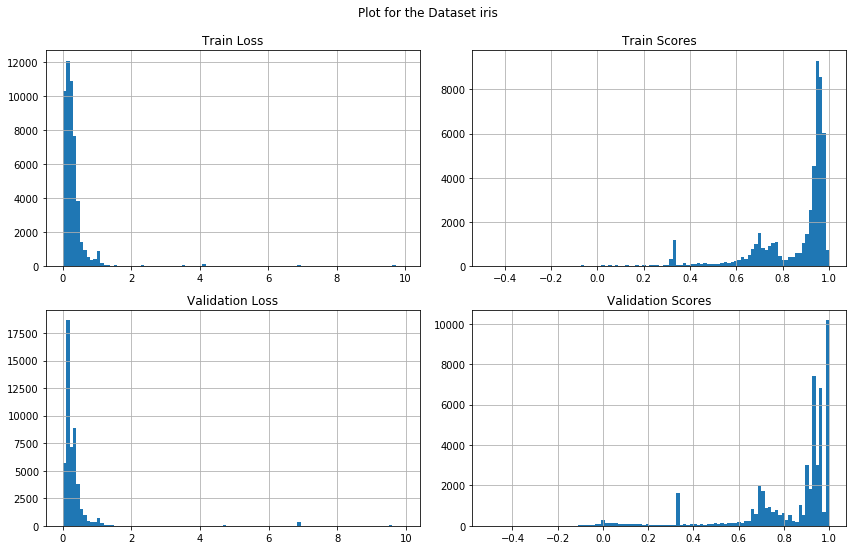

In [9]:
plot(df[using_iris], thresholds=(10, -1, 10, -1))

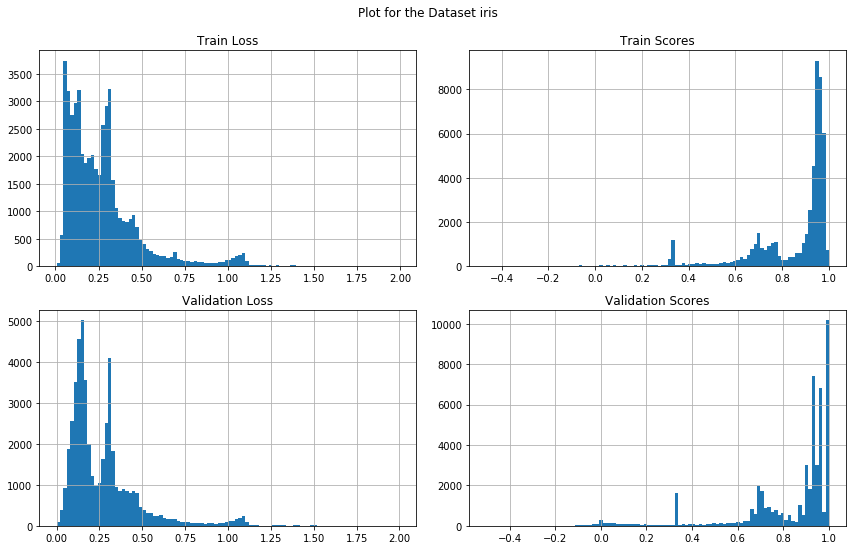

In [10]:
plot(df[using_iris], thresholds=(2, -1, 2, -1))

# Failure Rate
As observed in the notebook `Exploratory Data Analysis.ipynb`, there were a significant number of configurations that failed to converge. A model is considered to fail to converge if its score got stuck in the middle of its range. These values are 0.0 for regression tasks using Pearson's Correlation Coefficient or 0.5 RMSE loss - with the latter being more reliable; and 0.5 for accuracy in classification tasks.

Comparing the failure rate of all models by dataset, it is shown that the models trained on the Iris dataset are the most successful. Even though the boxplot would suggest that models trained on the encoder dataset are more successful, the small feature space makes me want to favour the models trained on the Iris dataset because I would believe these models to be more representative of artificial neural networks *in the wild* so to speak. 

Comparing the failure rate within the set of models trained on the Iris dataset reaffirms (although perhaps does not prove) the idea that the combination of the Leaky ReLU activation and a learning rate of 0.1 is correlated with poor model performance.

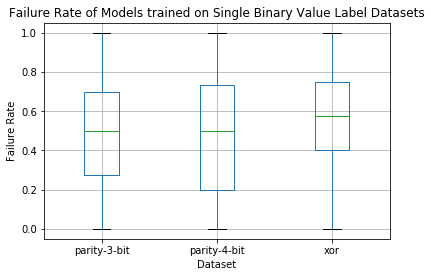

In [11]:
single_binary_output = df['dataset'].isin(['parity-3-bit', 'parity-4-bit', 'xor'])

ax = df[single_binary_output].boxplot(column='fail_rate', by='dataset')
ax.set_ylabel('Failure Rate')
ax.set_xlabel('Dataset')
ax.set_title('Failure Rate of Models trained on Single Binary Value Label Datasets')
plt.suptitle('');  # get rid of the generic title pandas gives us.

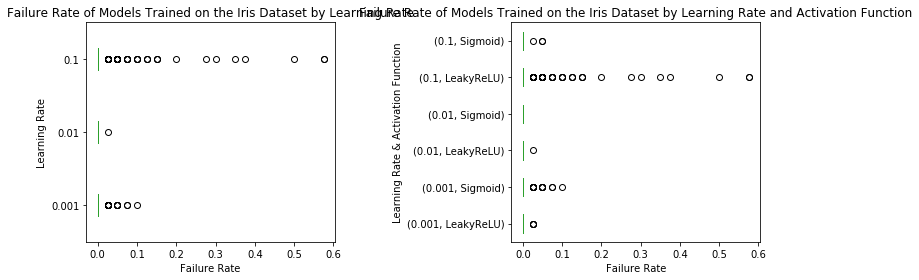

In [12]:
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(12, 4))

ax = df[using_iris].boxplot(column='fail_rate', by='learning_rate', 
                                  vert=False, grid=False, ax=axes[0])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Learning Rate')
ax.set_title('Failure Rate of Models Trained on the Iris Dataset by Learning Rate')

ax = df[using_iris].boxplot(column='fail_rate', by=['learning_rate', 'activation_func'], 
                                  vert=False, grid=False, ax=axes[1])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Learning Rate & Activation Function')
ax.set_title('Failure Rate of Models Trained on the Iris Dataset by Learning Rate and Activation Function')
plt.suptitle('');  # get rid of the generic title pandas gives us.
plt.tight_layout()

# ReLU or Sigmoid?
The activation functions used in the hidden layer that I explored were the leaky ReLU ($\alpha=0.1$) and the sigmoid activation functions. The ReLU family of activation functions have some advantages over the sigmoid activation function, particularly in deep neural networks [1]. However, it would seem that the unbounded nature of the ReLU activation function ends up causing some of the models to fail catastrophically, resulting in their  loss skyrocketing towards infinity.

[1] Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. "Deep sparse rectifier neural networks." In Proceedings of the fourteenth international conference on artificial intelligence and statistics, pp. 315-323. 2011.

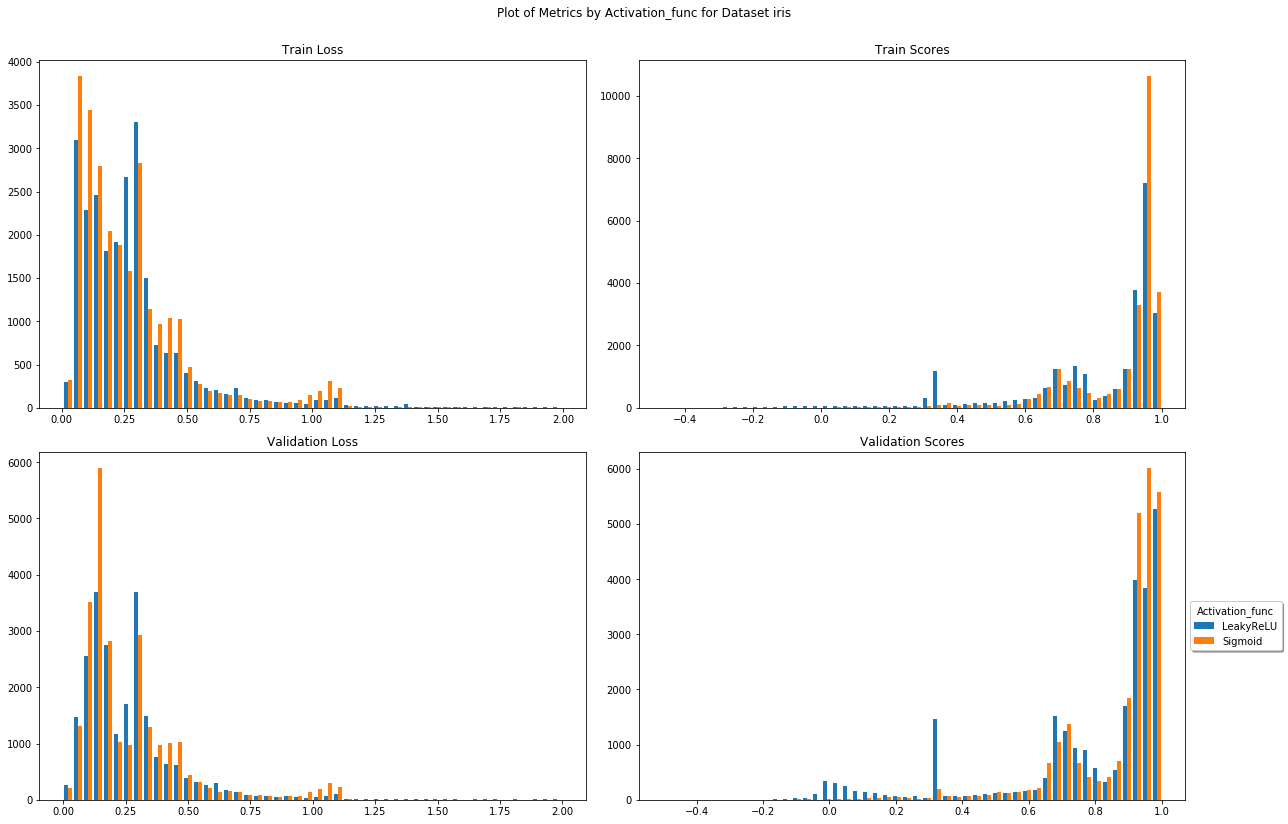

In [13]:
plot_hue(df[using_iris], hue='activation_func', thresholds=(2, -1, 2, -1))

It would seem that that the sigmoid activation function performs better. The graphs above would suggest that using a sigmoid activation function will result in lower loss and higher accuracy more often.

Now although the data is heavily skewed (and it is probably not even normally distributed), I will pretend that it is acceptable to apply Welch's t-test to the results of the models trained on the Iris datasets, with the groups of interest being the models trained with the sigmoid activation and those trained with the ReLU activation. The other hyperparameters are controlled for both groups. Unless otherwise stated, the null hypothesis is rejected when $p \leq .001$. The null hypothesis is that there is no difference between using ReLU or sigmoid activations.

While the t-test on the loss metrics do not appear to be statistically significant, judging from the other statistics it would seem sigmoid is better (i.e. lower loss) with an advantage at each quartile. Interestlingly though, we see that with ReLU activation a lower minimum training loss is achieved.

It seems that sigmoid provides a clear improvement in both training and validation scores with the t-test reporting strong effects with statistical significance (p < .001).

The t-test supports the claim that there is a higher failure rate when using ReLU activation (p < .001).

The results between regression and classification tasks (the distinction is important due to the different metrics used to measure model performance) mostly agree. However, the claim about higher failure rates with ReLU activation does not seem to hold in the context of classification tasks and in the classification tasks the difference in loss is considered statistically significant.

In [14]:
print('Key:')
print('a - Models using Sigmoid Activation')
print('b - Models using Leaky ReLU Activation')
print()

stat_test(df, using_iris, using_sigmoid, 'Comparison of Models Trained on the Iris Dataset by Activation function')

Key:
a - Models using Sigmoid Activation
b - Models using Leaky ReLU Activation

********************************************************************************
Comparison of Models Trained on the Iris Dataset by Activation function
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 646
min: 9.9160e-03 - max: 6.5633e+00
μ ± 2σ: 2.9107e-01 ± 9.5632e-02
Quartiles - 1st: 1.1311e-01 - 2nd: 2.1542e-01 - 3rd: 3.5181e-01

Summary for b:
n: 600
min: 6.6351e-03 - max: 1.1206e+152
μ ± 2σ: 5.2117e+147 ± 1.4170e+150
Quartiles - 1st: 1.3502e-01 - 2nd: 2.6530e-01 - 3rd: 3.6884e-01

Welch t-test:
t: -1.1729 - p: .449
############
train_scores
############
Summary for a:
n: 646
min: -4.6578e-01 - max: 1.0000e+00
μ ± 2σ: 8.7744e-01 ± 1.5483e-02
Quartiles - 1st: 8.5090e-01 - 2nd: 9.4529e-01 - 3rd: 9.6094e-01

Summary for b:
n: 603
min: -4.3910e-01 - max: 1.0000e+00
μ ± 2σ: 8.0488e-01 ± 1.3630e-02
Quartiles - 1st: 7.1780e-0

/home/anthony/miniconda3/envs/cosc420/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:1068: RuntimeWarning: overflow encountered in double_scalars
  df = (vn1 + vn2)**2 / (vn1**2 / (n1 - 1) + vn2**2 / (n2 - 1))


Summary for a:
n: 646
min: -5.0256e-01 - max: 1.0000e+00
μ ± 2σ: 8.7580e-01 ± 1.4479e-02
Quartiles - 1st: 8.3333e-01 - 2nd: 9.3333e-01 - 3rd: 9.6667e-01

Summary for b:
n: 602
min: -4.1972e-01 - max: 1.0000e+00
μ ± 2σ: 7.8586e-01 ± 1.1213e-02
Quartiles - 1st: 6.9884e-01 - 2nd: 9.1756e-01 - 3rd: 9.6667e-01

Welch t-test:
t: 46.1162 - p: <.001
#########
fail_rate
#########
Summary for a:
n: 648
min: 0.0000e+00 - max: 1.0000e-01
μ ± 2σ: 1.2346e-03 ± nan
Quartiles - 1st: 0.0000e+00 - 2nd: 0.0000e+00 - 3rd: 0.0000e+00

Summary for b:
n: 648
min: 0.0000e+00 - max: 5.7500e-01
μ ± 2σ: 9.2207e-03 ± nan
Quartiles - 1st: 0.0000e+00 - 2nd: 0.0000e+00 - 3rd: 0.0000e+00

Welch t-test:
t: -4.0902 - p: <.001


In [15]:
stat_test(df, using_iris & using_regression, using_sigmoid, 'Comparison of Regresssion Models Trained on the Iris Dataset by Activation function')

********************************************************************************
Comparison of Regresssion Models Trained on the Iris Dataset by Activation function
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 324
min: 2.8076e-02 - max: 5.9152e-01
μ ± 2σ: 2.0258e-01 ± 3.0320e-03
Quartiles - 1st: 1.1897e-01 - 2nd: 1.7491e-01 - 3rd: 2.9119e-01

Summary for b:
n: 285
min: 4.8504e-02 - max: 1.1206e+152
μ ± 2σ: 1.0445e+148 ± 2.0056e+150
Quartiles - 1st: 1.4903e-01 - 2nd: 2.7218e-01 - 3rd: 3.1900e-01

Welch t-test:
t: -1.1729 - p: .449
############
train_scores
############
Summary for a:
n: 324
min: -4.6578e-01 - max: 9.9615e-01
μ ± 2σ: 8.4565e-01 ± 2.0925e-02
Quartiles - 1st: 7.2141e-01 - 2nd: 9.4078e-01 - 3rd: 9.5258e-01

Summary for b:
n: 285
min: -4.3910e-01 - max: 9.8501e-01
μ ± 2σ: 7.3903e-01 ± 2.2270e-02
Quartiles - 1st: 6.7314e-01 - 2nd: 7.6661e-01 - 3rd: 9.3651e-01

Welch t-test:
t: 40.7728 - p: 

In [16]:
print('Key:')
print('a - Models using Sigmoid Activation')
print('b - Models using Leaky ReLU Activation')
print()

stat_test(df, using_iris & using_classification, using_sigmoid, 'Comparison of Classification Models Trained on the Iris Dataset by Activation function')

Key:
a - Models using Sigmoid Activation
b - Models using Leaky ReLU Activation

********************************************************************************
Comparison of Classification Models Trained on the Iris Dataset by Activation function
********************************************************************************
##########
train_loss
##########
Summary for a:
n: 322
min: 9.9160e-03 - max: 6.5633e+00
μ ± 2σ: 3.7958e-01 ± 1.3927e-01
Quartiles - 1st: 8.7528e-02 - 2nd: 2.9105e-01 - 3rd: 4.7254e-01

Summary for b:
n: 315
min: 6.6351e-03 - max: 1.9342e+01
μ ± 2σ: 7.3320e-01 ± 4.6859e-01
Quartiles - 1st: 8.5088e-02 - 2nd: 2.4892e-01 - 3rd: 4.9060e-01

Welch t-test:
t: -20.9569 - p: <.001
############
train_scores
############
Summary for a:
n: 322
min: 8.3333e-03 - max: 1.0000e+00
μ ± 2σ: 9.0923e-01 ± 1.7847e-02
Quartiles - 1st: 9.0781e-01 - 2nd: 9.5312e-01 - 3rd: 9.7500e-01

Summary for b:
n: 318
min: 0.0000e+00 - max: 1.0000e+00
μ ± 2σ: 8.6973e-01 ± 1.6605e-02
Quartiles - 1s

# Appropriate Batch Size
What is the best batch size? The batch sizes tested were 1 (equivalent to standard SGD), 2, 4, 8, 16, 32, and $N$ (i.e. batch SGD).

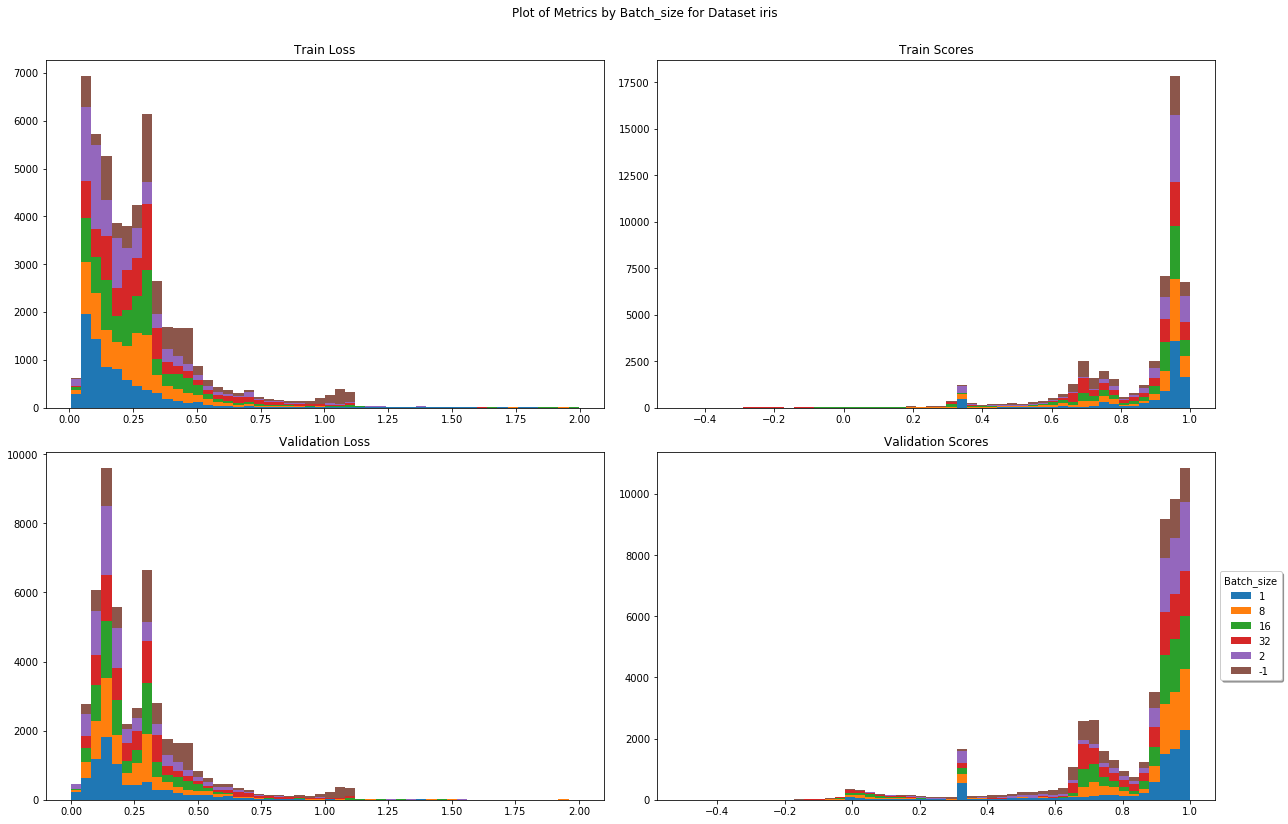

In [17]:
plot_hue(df[using_iris], hue='batch_size', stacked=True, thresholds=(2, -1, 2, -1))